# Fraud Detection: Data Preprocessing and Exploratory Analysis

This notebook covers the complete preprocessing pipeline for fraud detection, including:
1. Loading and exploring the dataset
2. Handling missing values
3. Analyzing and visualizing class imbalance
4. Feature engineering and encoding categorical variables
5. Feature scaling and normalization
6. Addressing class imbalance using SMOTE
7. Train/test splitting with stratification
8. Visualizing key insights

Date: April 27, 2025

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from pathlib import Path
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For addressing class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# For evaluating preprocessing
from sklearn.metrics import classification_report, confusion_matrix

# Set visualization styles
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Explore the Dataset

We'll load the PaySim dataset and perform initial exploratory analysis.

In [2]:
# Define paths
RAW_DATA_PATH = Path("../../data/raw/ps_raw.csv")

# Load the dataset
def load_data(filepath):
    print(f"Loading data from {filepath}")
    return pd.read_csv(filepath)

# Load the data
df = load_data(RAW_DATA_PATH)

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Loading data from ..\..\data\raw\ps_raw.csv
Dataset shape: (6362620, 11)
Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Check data types, missing values, and basic statistics
print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
df.describe().T


Data Types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Basic Statistics:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Basic Statistics:


,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


## 3. Analyze Class Imbalance

Let's examine the distribution of the target variable to understand the class imbalance.

In [4]:
# Identify target column - 'isFraud' in our case
target_column = 'isFraud'

# Check class distribution
class_counts = df[target_column].value_counts()
class_distribution = df[target_column].value_counts(normalize=True) * 100

print(f"Class counts:\n{class_counts}")
print(f"\nClass distribution (%):\n{class_distribution}")

# Calculate imbalance ratio
imbalance_ratio = class_counts[1] / class_counts[0]
print(f"\nImbalance ratio (fraud/non-fraud): {imbalance_ratio:.6f}")

Class counts:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Class distribution (%):
isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

Imbalance ratio (fraud/non-fraud): 0.001292


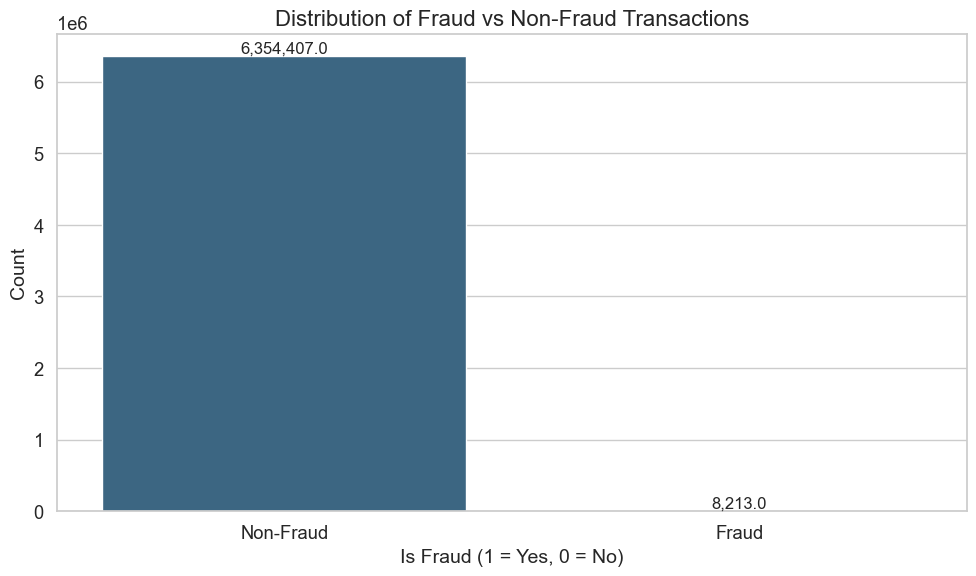

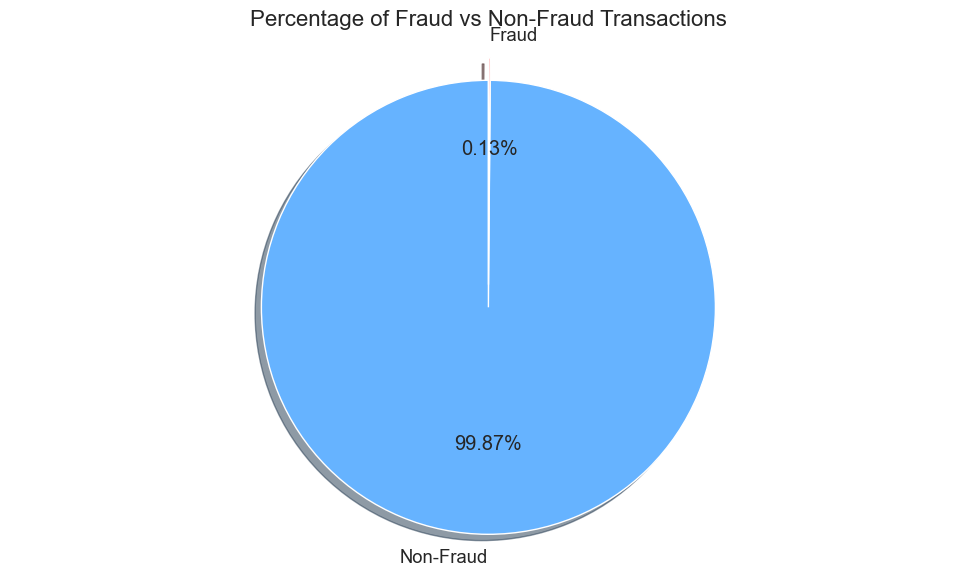

In [5]:
# Visualize class distribution with bar plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=target_column, data=df, palette='viridis')

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Fraud vs Non-Fraud Transactions', fontsize=16)
plt.xlabel('Is Fraud (1 = Yes, 0 = No)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

# Pie chart for better visual representation
labels = ['Non-Fraud', 'Fraud']
sizes = class_counts.values
explode = (0, 0.1)  # explode the 2nd slice (Fraud)

fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
       shadow=True, startangle=90, colors=['#66b3ff', '#ff9999'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Percentage of Fraud vs Non-Fraud Transactions', fontsize=16)
plt.tight_layout()
plt.show()

## 4. Feature Engineering and Exploratory Data Analysis

Let's explore the relationships between features and the target variable.

In [6]:
# Feature engineering: Create additional features if needed
# For example, we might create ratio features, time-based features, etc.

# Let's identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target column from numerical columns if it exists there
if target_column in numerical_cols:
    numerical_cols.remove(target_column)

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['type', 'nameOrig', 'nameDest']
Numerical columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


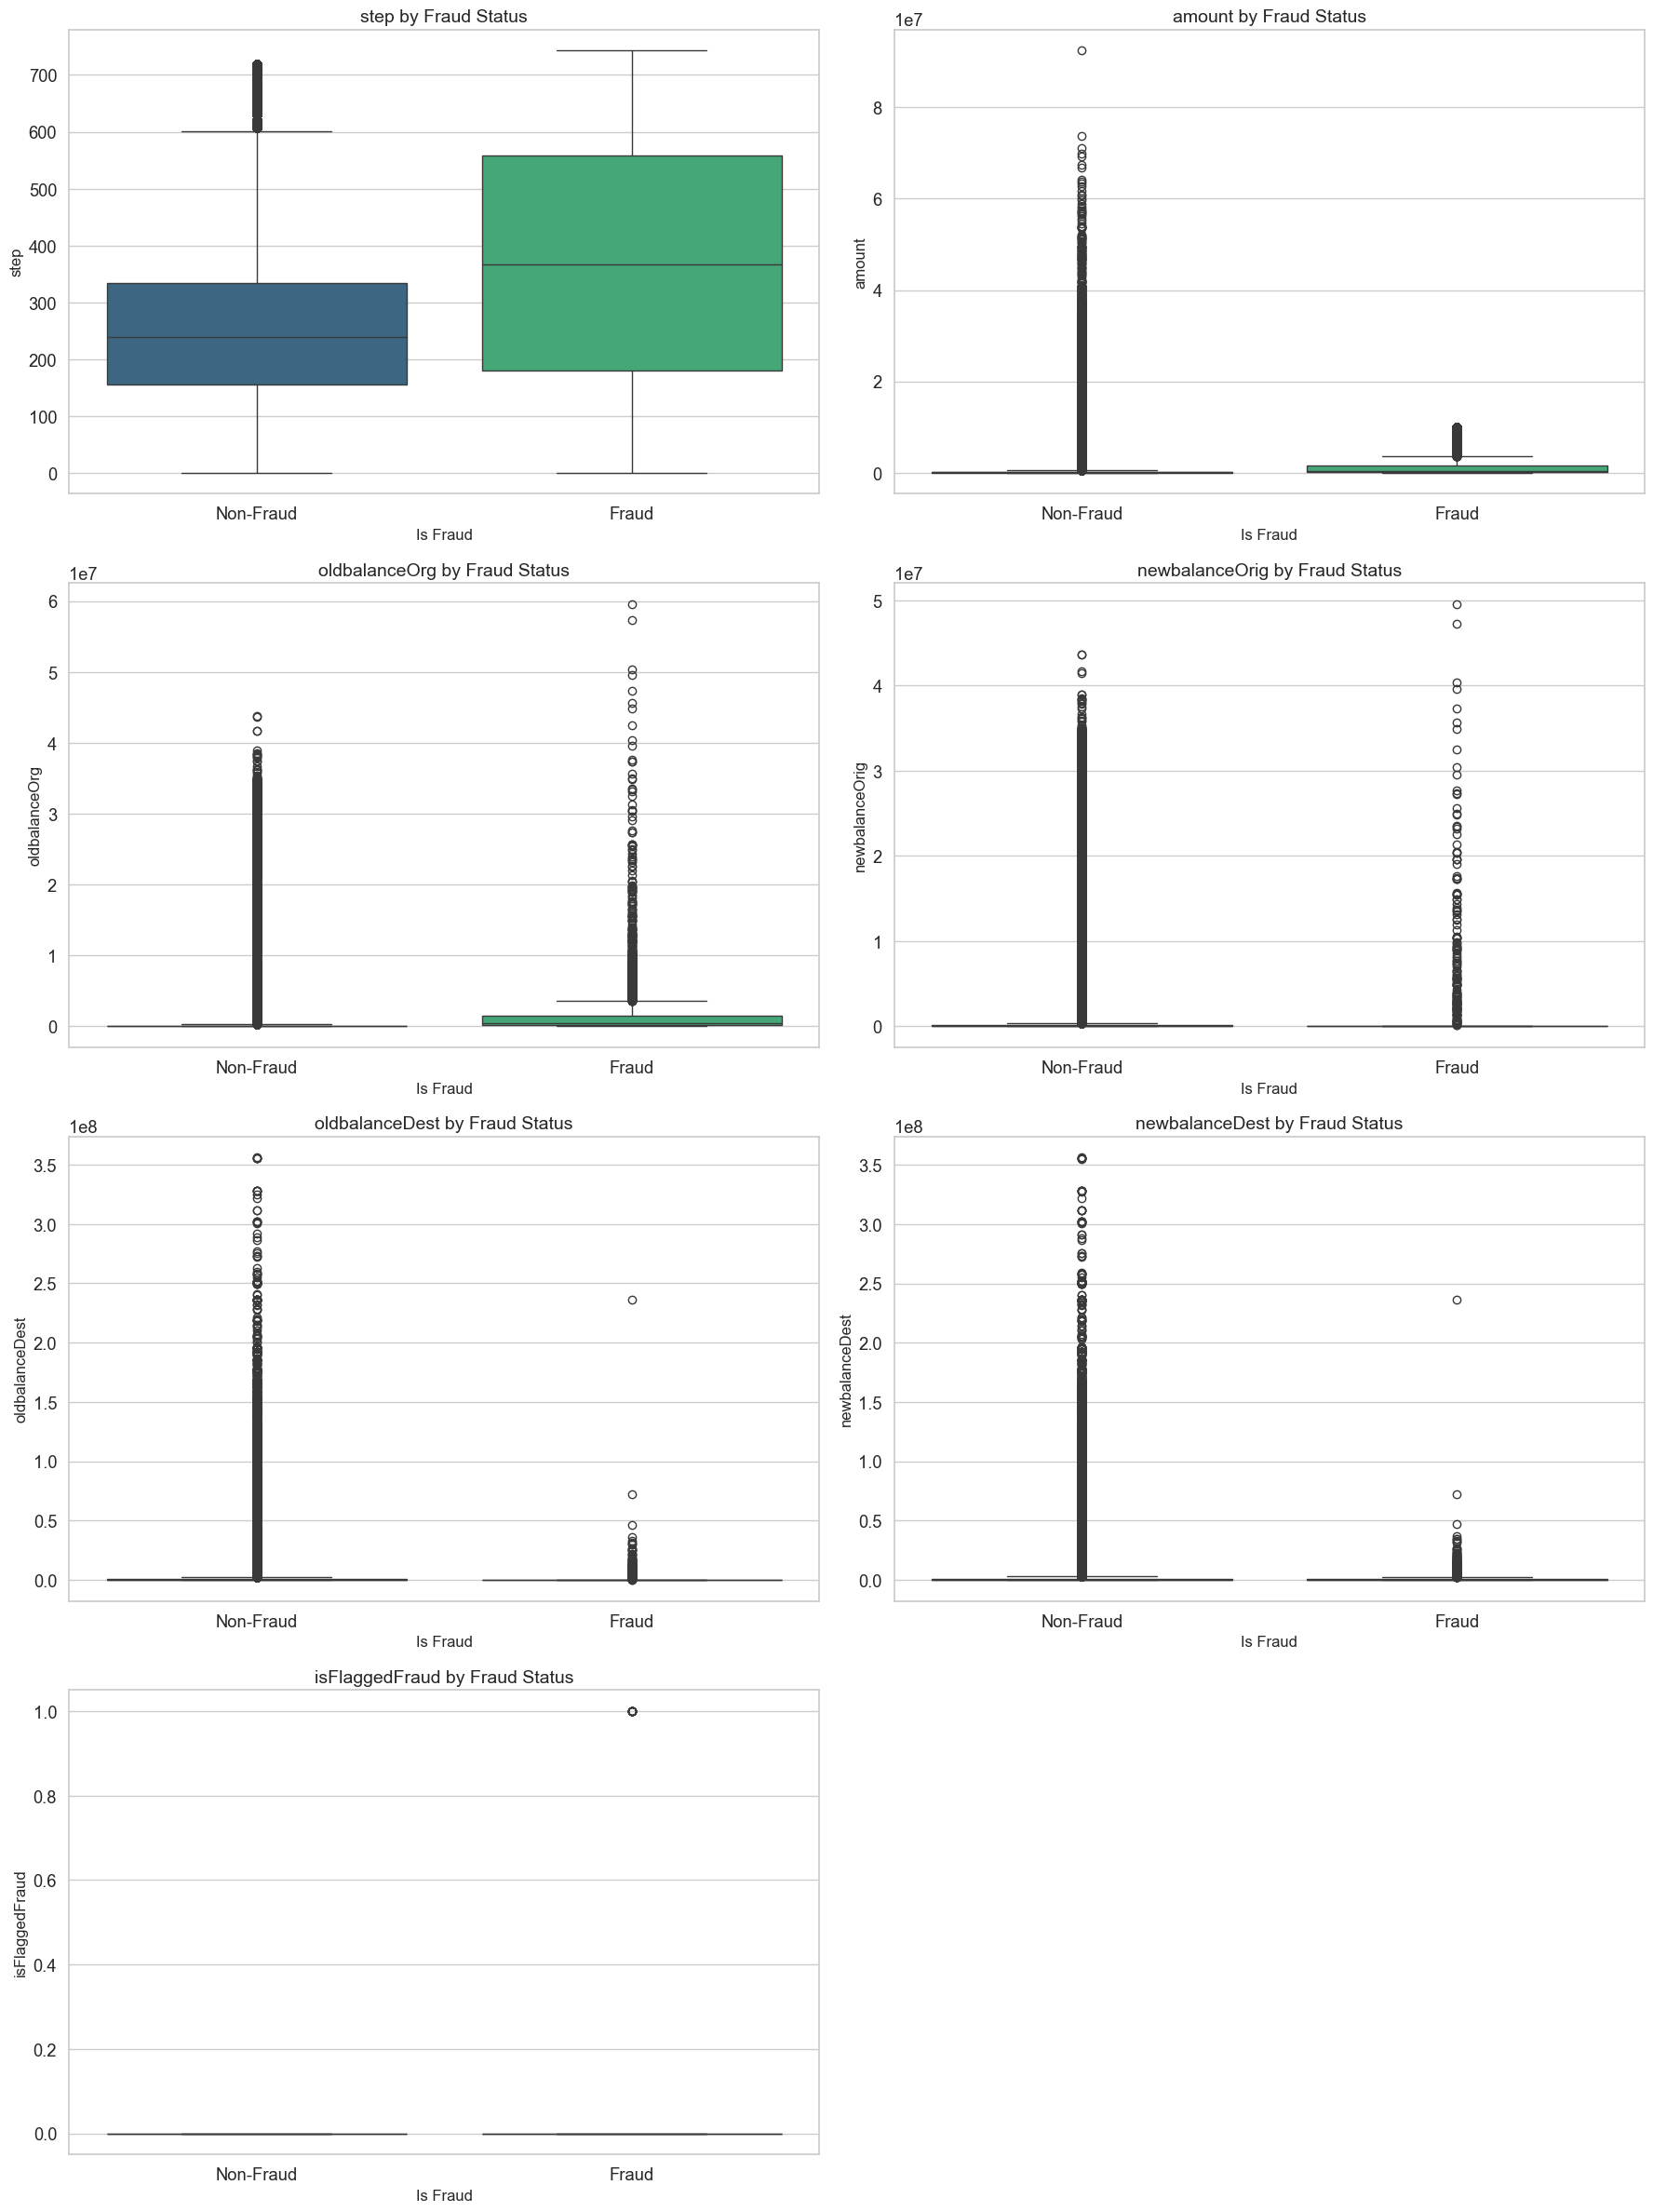

In [8]:
# Analyze numerical features
if numerical_cols:
    # Create a boxplot for each numerical feature by fraud status
    n_cols = 2
    n_rows = (len(numerical_cols) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            sns.boxplot(x=target_column, y=col, data=df, palette='viridis', ax=axes[i])
            axes[i].set_title(f'{col} by Fraud Status', fontsize=14)
            axes[i].set_xlabel('Is Fraud', fontsize=12)
            axes[i].set_ylabel(col, fontsize=12)
            axes[i].set_xticklabels(['Non-Fraud', 'Fraud'])
            
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()

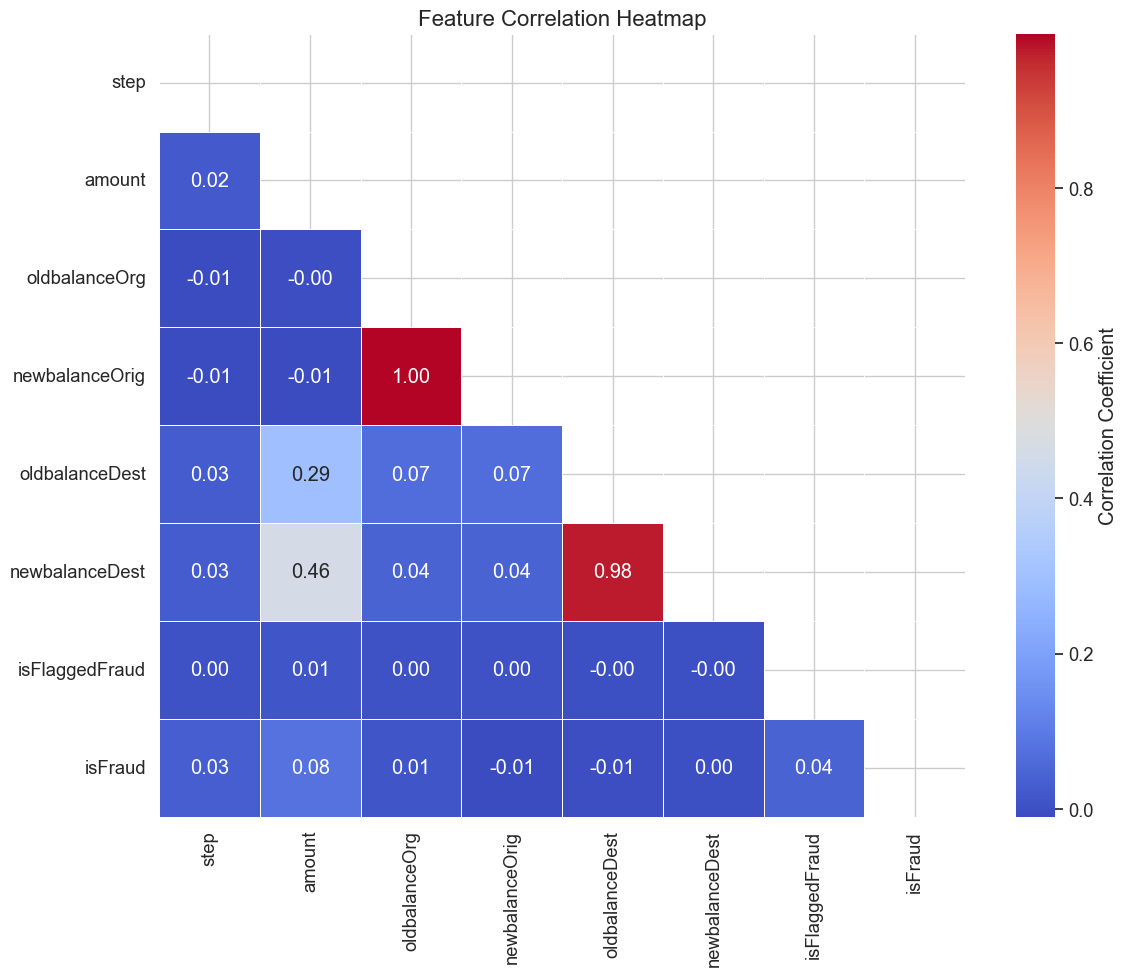

Feature correlations with target:
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


In [9]:
# Create a correlation heatmap for numerical features
if numerical_cols:
    # Add target column to create correlation
    corr_cols = numerical_cols + [target_column]
    corr_matrix = df[corr_cols].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f',
                linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Feature Correlation Heatmap', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corrs = corr_matrix[target_column].drop(target_column).sort_values(ascending=False)
    print("Feature correlations with target:")
    print(target_corrs)

## 5. Feature Preprocessing

Let's encode categorical variables and scale numerical features.

In [11]:
# Encode categorical variables
def encode_categoricals(df, categorical_cols):
    df_encoded = df.copy()
    
    # Identify different types of categorical columns
    binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]
    multi_class_cols = [col for col in categorical_cols if 2 < df[col].nunique() <= 10]  # Multi-class with few categories
    high_card_cols = [col for col in categorical_cols if df[col].nunique() > 10]  # High cardinality columns
    
    print(f"Binary columns: {binary_cols}")
    print(f"Multi-class columns (low cardinality): {multi_class_cols}")
    print(f"High cardinality columns: {high_card_cols}")
    
    # Label encode binary columns
    le = LabelEncoder()
    for col in binary_cols:
        df_encoded[col] = le.fit_transform(df[col])
    
    # One-hot encode multi-class columns with low cardinality
    if multi_class_cols:
        df_encoded = pd.get_dummies(df_encoded, columns=multi_class_cols, drop_first=True)
    
    # For high cardinality columns, extract useful features instead of one-hot encoding
    for col in high_card_cols:
        if col in ['nameOrig', 'nameDest']:
            # Extract the first character as a feature (e.g., C for Customer, M for Merchant)
            df_encoded[f"{col}_prefix"] = df[col].str[0]
            
            # One-hot encode this prefix which should have low cardinality
            df_encoded = pd.get_dummies(df_encoded, columns=[f"{col}_prefix"], drop_first=True)
            
            # Drop the original high cardinality column
            df_encoded.drop(col, axis=1, inplace=True)
    
    return df_encoded

# Apply encoding if we have categorical columns
if categorical_cols:
    df_encoded = encode_categoricals(df, categorical_cols)
    print(f"Shape after encoding: {df_encoded.shape}")
    df_encoded.head()
else:
    df_encoded = df.copy()
    print("No categorical columns to encode.")

Binary columns: []
Multi-class columns (low cardinality): ['type']
High cardinality columns: ['nameOrig', 'nameDest']
Shape after encoding: (6362620, 13)
Shape after encoding: (6362620, 13)


In [12]:
# Scale numerical features
def scale_features(df, numerical_cols, scaler_type='standard'):
    df_scaled = df.copy()
    
    if scaler_type == 'standard':
        scaler = StandardScaler()
    else:  # minmax scaler
        scaler = MinMaxScaler()
    
    if numerical_cols:
        df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    return df_scaled, scaler

# Apply scaling if we have numerical columns
if numerical_cols:
    df_preprocessed, scaler = scale_features(df_encoded, numerical_cols, 'standard')
    print(f"Shape after scaling: {df_preprocessed.shape}")
    df_preprocessed.head()
else:
    df_preprocessed = df_encoded.copy()
    print("No numerical columns to scale.")

Shape after scaling: (6362620, 13)


## 6. Split Data into Train and Test Sets

In [13]:
# Split data into features and target
X = df_preprocessed.drop(target_column, axis=1)
y = df_preprocessed[target_column]

# Split into train and test sets with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Check class distribution in train and test sets
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)

print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

Training set shape: (5090096, 12)
Testing set shape: (1272524, 12)

Class distribution in training set:
isFraud
0    99.870926
1     0.129074
Name: proportion, dtype: float64

Class distribution in testing set:
isFraud
0    99.870887
1     0.129113
Name: proportion, dtype: float64


## 7. Handle Class Imbalance with SMOTE

We'll use Synthetic Minority Over-sampling Technique (SMOTE) to address class imbalance.

In [14]:
# Apply SMOTE to balance the training set
def balance_data(X_train, y_train, method='smote', sampling_strategy=1.0):
    print(f"Before balancing: {y_train.value_counts()}")
    
    if method == 'smote':
        resampler = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    elif method == 'undersample':
        resampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    else:
        raise ValueError("Method must be 'smote' or 'undersample'")
    
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    print(f"After balancing: {pd.Series(y_resampled).value_counts()}")
    
    # Calculate change in class distribution
    before_ratio = y_train.value_counts()[1] / y_train.value_counts()[0]
    after_ratio = pd.Series(y_resampled).value_counts()[1] / pd.Series(y_resampled).value_counts()[0]
    
    print(f"Before balancing - Fraud/Non-fraud ratio: {before_ratio:.6f}")
    print(f"After balancing - Fraud/Non-fraud ratio: {after_ratio:.6f}")
    
    return X_resampled, y_resampled

# Apply SMOTE with 1:1 ratio
X_train_balanced, y_train_balanced = balance_data(X_train, y_train, method='smote', sampling_strategy=1.0)

Before balancing: isFraud
0    5083526
1       6570
Name: count, dtype: int64
After balancing: isFraud
0    5083526
1    5083526
Name: count, dtype: int64
Before balancing - Fraud/Non-fraud ratio: 0.001292
After balancing - Fraud/Non-fraud ratio: 1.000000
After balancing: isFraud
0    5083526
1    5083526
Name: count, dtype: int64
Before balancing - Fraud/Non-fraud ratio: 0.001292
After balancing - Fraud/Non-fraud ratio: 1.000000


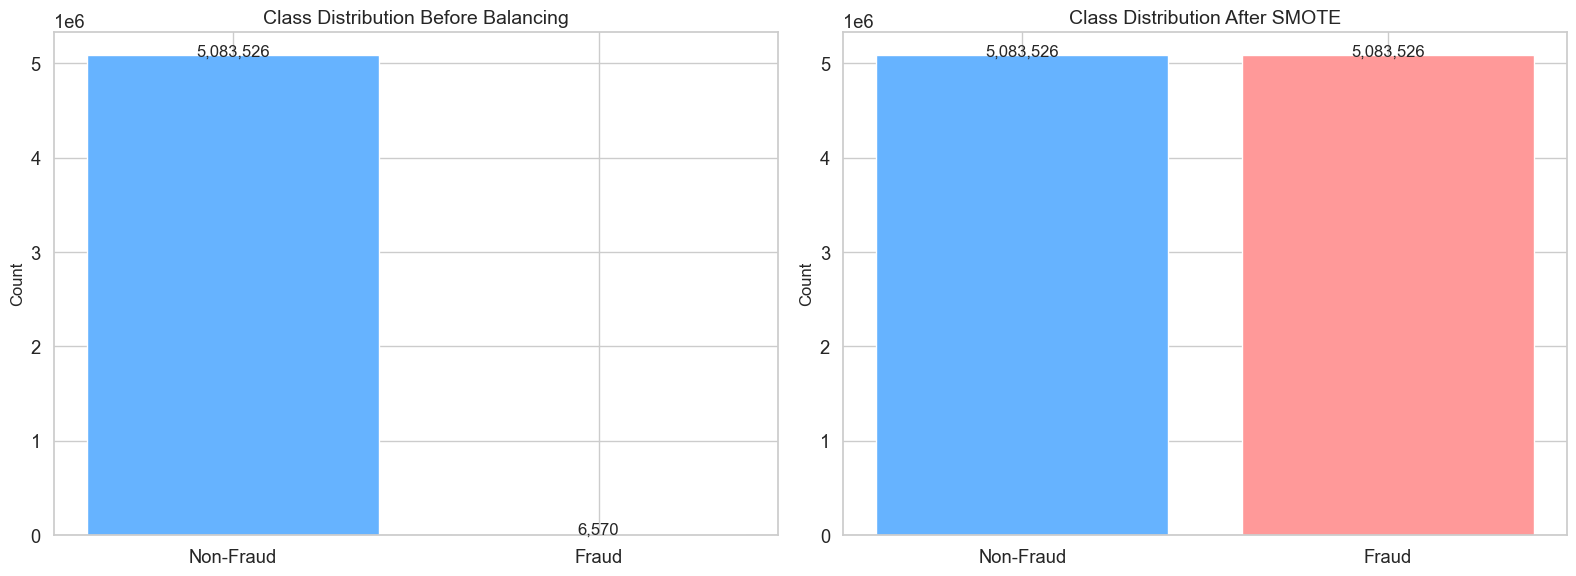

In [15]:
# Visualize class distribution before and after balancing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Before balancing
y_train_counts = y_train.value_counts()
ax1.bar([0, 1], y_train_counts.values, color=['#66b3ff', '#ff9999'])
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Non-Fraud', 'Fraud'])
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Class Distribution Before Balancing', fontsize=14)
for i, v in enumerate(y_train_counts.values):
    ax1.text(i, v + 0.1, f'{v:,}', ha='center', fontsize=12)

# After balancing
y_balanced_counts = pd.Series(y_train_balanced).value_counts()
ax2.bar([0, 1], y_balanced_counts.values, color=['#66b3ff', '#ff9999'])
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Non-Fraud', 'Fraud'])
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Class Distribution After SMOTE', fontsize=14)
for i, v in enumerate(y_balanced_counts.values):
    ax2.text(i, v + 0.1, f'{v:,}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## 8. Save Preprocessed Data

Let's save our preprocessed data for future use.

In [16]:
def save_data(X_train, X_test, y_train, y_test, balanced=False, save_dir='../../data/processed'):
    os.makedirs(save_dir, exist_ok=True)
    
    # Create prefix for balanced data
    prefix = "balanced_" if balanced else ""
    
    # Save data
    X_train.to_csv(os.path.join(save_dir, f"{prefix}X_train.csv"), index=False)
    X_test.to_csv(os.path.join(save_dir, f"{prefix}X_test.csv"), index=False)
    
    # Convert to DataFrame if Series
    if not isinstance(y_train, pd.DataFrame):
        y_train = pd.DataFrame(y_train, columns=[target_column])
    if not isinstance(y_test, pd.DataFrame):
        y_test = pd.DataFrame(y_test, columns=[target_column])
        
    y_train.to_csv(os.path.join(save_dir, f"{prefix}y_train.csv"), index=False)
    y_test.to_csv(os.path.join(save_dir, f"{prefix}y_test.csv"), index=False)
    
    print(f"Saved preprocessed data to {save_dir}")

# Save original split data
save_data(X_train, X_test, y_train, y_test)

# Save balanced data
save_data(pd.DataFrame(X_train_balanced, columns=X_train.columns), 
          X_test, 
          pd.Series(y_train_balanced, name=target_column), 
          y_test, 
          balanced=True)

Saved preprocessed data to ../../data/processed
Saved preprocessed data to ../../data/processed
Saved preprocessed data to ../../data/processed
